In [1]:
import os
import numpy as np
import cv2
import math
import matplotlib.pyplot as plt
import sklearn
from tensorflow.keras import backend as K
from scipy.io import loadmat

In [2]:
print(os.listdir())

['yAxis.npy', 'xAxis.npy', 'DataPlayground.ipynb', '.ipynb_checkpoints']


In [3]:
IPH_patients = [8, 9, 10, 12, 22, 47, 53, 62, 66, 67, 69, 74, 75, 78, 85, 89, 93,
                101, 105, 107, 110, 112, 113, 120, 121, 126, 129, 130, 133]

bad_patients = [1, 14, 22, 23, 27, 28, 32, 34, 35, 36, 37, 38, 39, 44, 49, 69, 71, 
                78, 82, 90, 98, 101, 121, 124, 128, 133, 928]

In [39]:
# Extract axis information to produce cone-shape images
def FetchAxis(datapath, axisPath):
    data = loadmat(datapath)

    xaxis = np.array(list(data['xAxis']))
    yaxis = np.array(list(data['zAxis']))

    xaxis = cv2.resize(xaxis, (80, 256), interpolation=cv2.INTER_AREA)
    yaxis = cv2.resize(yaxis, (80, 256), interpolation=cv2.INTER_AREA)

    xaxis += 100
    yaxis -= 4

    print("saved axis info in : {}".format(axisPath))
    np.save(os.path.join(axisPath, "xAxis.npy"), xaxis)
    np.save(os.path.join(axisPath, "yAxis.npy"), yaxis)
    
    return xaxis, yaxis

In [40]:
# extract axis information
axisPath = "/DATA/phan92/notebooks"
rand_input_file = "/DATA/phan92/test_resource/raw_data/DoD110/DoD110_Ter002_LO1_Displacement_Normalized_3.mat"
xAxis, yAxis = FetchAxis(rand_input_file, axisPath)

saved axis info in : /DATA/phan92/notebooks


In [ ]:
def normalize_displacement(displace_data):
    """
    Normalize displacement data

    Args:
        displace_data (numpy array): 10 points of displacement data in a cardiac cycle
    Return:
        displace_data (numpy array): one image = average of the 10 points
    """
    displace_data = displace_data - displace_data.mean(axis=0).mean(axis = 0)
    safe_max = np.abs(displace_data).max(axis=0).max(axis=0)
    safe_max[safe_max == 0] = 1
    displace_data = displace_data / safe_max 
    displace_data = cv2.resize(displace_data, (80, 256))

    return displace_data

In [ ]:
def extract_displace_data(rawData):
    """
    Extract the displacement data from a patient file.
    Ignore the last cardiac cycle.
    Take 10 points from the start of a cardiac cycel

    Args:
        rawData (raw from .mat): raw data loaded from .mat file

    Return:
        displace_data (numpy array): displacement data
    """
    displacement = np.array(list(rawData['displacement']))
    hrTimes = np.array(list(rawData['hrTimes']))
    hrShape = hrTimes.shape
    disShape = displacement.shape
    displace_data = np.zeros([disShape[0], disShape[1], 10, hrShape[1] - 1])
    for h in range(0, hrShape[1] - 1):
        start = int(math.ceil(30 * hrTimes[0, h]))
        displace_data[:, :, :, h] = displacement[:, :, start: start + 10]
    
    return np.array(displace_data.astype('float64'))

In [ ]:
def process_patients(path, objective, patient_num=None):
    """
    Process data of all patients

    Args:
        path (string): path to folder storing patient data
        objective (integer): 0-brain mask, 1-blood mask
        patient_num (int): not used currently
    Return:
        1. numpy array of displacement data, label, and bMode
        2. list of patient files
    """
    patients_data = []
    file_list = []
    for patient in os.listdir(path):
        dataPath = os.path.join(path, patient)
        data, fileNames = process_data(path=dataPath, objective=objective)
        patients_data.append(data)
        file_list.append(fileNames)
    
    return np.array(patients_data), np.array(file_list)

In [ ]:
def process_data(path, objective):
    """
    Process the raw data for a patient
    """
    # list of input images
    data = []
    # list of file names
    fileNames = []
    # process all file in the directory
    for file in os.listdir(path):
        if ".mat" in file:
            print(file)               # to be removed
            filePath = os.path.join(path, file)
            fileName = file[0:17]
            rawData = loadmat(filePath)
            # get the labels
            normalMask = np.array(list(rawData['normalMask'])) 
            bloodMask = np.array(list(rawData['bloodMaskThick']))
            brainMask = np.array(list(rawData['brainMask']))
            bMode = np.array(list(rawData['bModeNorm']))

            if len(bloodMask) == 0:
                break
            
            # extract the displacement data
            displace_data = extract_displace_data(rawData)
            
            # resize the masks
            normalMask = cv2.resize(normalMask, (80, 256))
            bloodMask = cv2.resize(bloodMask, (80, 256))
            brainMask = cv2.resize(brainMask, (80, 256))
            bMode = np.log10(bMode)
            bMode = bMode.astype('float64')
            bMode = np.mean(bMode, axis=2)

            # create label
            if objective == 0:
                label = np.where(brainMask == 0, 0, 1)
            else:
                label = bloodMask + 1
                label = label.astype('float32')
                label = np.where(brainMask == 0, 0, label)

            label = label.reshape([256, 80, 1])
            n_cycles = displace_data.shape[-1]

            # normalize
            for k in range(0, n_cycles):
                displace_data0 = displace_data[:, :, :, k]
                displace_data0 = normalize_displacement(displace_data0)
                
                bMode0 = bMode[:, :, k]
                bMode0 = cv2.resize(bMode0, (80, 256))
                bMode0 = bMode0.reshape([256, 80, 1])

                if objective == 1:
                    # delete non-brain from input
                    for i in range(0, displace_data0.shape[-1]):
                        displace_data0[:, :, i] = np.where(brainMask == 0, 0.0, displace_data0[:, :, i])

                # concatenate into one structure
                sample = np.concatenate((label, displace_data0, bMode0), axis=2)
                
            data.append(sample)
            fileNames.append(fileName + '_cycle' + str(k))
            print("Data shape:", np.array(data).shape)
    return np.array(data), np.array(fileNames)

In [ ]:
def split_data(data, nameList, savePath, test_size=0.2, random_state=42):
    """
    Split the data into train and test set and save to file
    
    Args:
        data (numpy array): the data to operate on
        pathList (numpy array): the list of file name correspond to the data
        test_size (float): the propotion of the test set
        random_state (int): maintain the consistency between the data and file names
    
    Return: None
    """
    train_data, test_data, train_list, test_list = train_test_split(
                                                        data, 
                                                        nameList,
                                                        test_size=test_size,
                                                        random_state=random_state
                                                    )
    np.save(os.path.join(savePath, "TrainingData.npy"), train_data)
    np.save(os.path.join(savePath, "TestingData.npy"), test_data)
    np.save(os.path.join(savePath, "TrainingPaths.npy"), train_list)
    np.save(os.path.join(savePath, "TestingPaths.npy"), test_list)

In [ ]:
# path to raw data
rawDataPath = "/DATA/phan92/test_resource/raw_data"
#path to saved processed data
savePath = os.getcwd()

In [ ]:
# get data from file
data, fileList = process_patients(rawDataPath, objective=1)

In [ ]:
def DispInput(x, mode):
    xshape = x.shape
    """
    for i in range(0, xshape[3]):
        tempx = x[:, :, :, i]
        plt.grid(False)
        plt.imshow(tempx, cmap='winter')
        plt.show() """
    image = x[0]
    image = image.reshape([256, 80, 12])
    
    if mode == 0:
        image = image[:, :, 0]
        image.reshape([256, 80])
        plt.pcolormesh(xAxis, -yAxis, image, shading='auto', cmap='magma', vmin=0, vmax=2)
    elif mode == 1:
        image = image[:, :, 11]
        image.reshape([256, 80])
        _, bin_edges = np.histogram(image, bins=25)
        plt.pcolormesh(xAxis, -yAxis, image, shading='auto', cmap='binary', vmin=bin_edges[2], vmax=bin_edges[-2])
    else:
        image = image[:, :, 1]
        image.reshape([256, 80])
        plt.pcolormesh(xAxis, -yAxis, image, shading='auto', cmap='nipy_spectral')
    plt.show()

In [ ]:
DispInput(data, 0)

In [ ]:
DispInput(data, 1)

In [ ]:
DispInput(data, 2)

# Descriptive statistics of the data

In [4]:
rawDataPath = '/DATA/phan92/raw_data/cardiac_displacement_3_updated_Oct13'

In [5]:
data = []
fileNames = []

In [6]:
# collect the data
for patient in os.listdir(rawDataPath):
    print(patient)
    patient_num = int(patient[3:])
    print(patient_num)
    if patient_num not in bad_patients:
        patientPath = os.path.join(rawDataPath, patient)
        for scan in os.listdir(patientPath):
            scanPath = os.path.join(patientPath, scan)
            fileNames.append(scanPath)
            rawData = loadmat(scanPath)
            displacement = np.array(list(rawData['displacement']))
            hrTimes = np.array(list(rawData['hrTimes']))
            hrShape = hrTimes.shape
            disShape = displacement.shape
            for h in range(0, hrShape[1] - 1):
                start = int(math.ceil(30 * hrTimes[0, h]))
                # get 10 points after start of a cardiac cycle
                for i in range(0, 11):
                    data.append(displacement[:, :, start + i])

DoD017
17
DoD052
52
DoD007
7
DoD098
98
DoD049
49
DoD124
124
DoD028
28
DoD047
47
DoD116
116
DoD084
84
DoD008
8
DoD037
37
DoD055
55
DoD016
16
DoD023
23
DoD112
112
DoD068
68
DoD093
93
DoD102
102
DoD058
58
DoD075
75
DoD107
107
DoD021
21
DoD083
83
DoD001
1
DoD121
121
DoD100
100
DoD036
36
DoD082
82
DoD060
60
DoD077
77
DoD042
42
DoD002
2
DoD032
32
DoD034
34
DoD070
70
DoD106
106
DoD073
73
DoD010
10
DoD039
39
DoD014
14
DoD120
120
DoD101
101
DoD067
67
DoD113
113
DoD088
88
DoD069
69
DoD131
131
DoD103
103
DoD005
5
DoD064
64
DoD074
74
DoD097
97
DoD111
111
DoD126
126
DoD009
9
DoD090
90
DoD045
45
DoD050
50
DoD125
125
DoD053
53
DoD062
62
DoD087
87
DoD006
6
DoD122
122
DoD110
110
DoD018
18
DoD033
33
DoD078
78
DoD065
65
DoD027
27
DoD072
72
DoD024
24
DoD130
130
DoD089
89
DoD025
25
DoD003
3
DoD063
63
DoD099
99
DoD035
35
DoD013
13
DoD081
81
DoD071
71
DoD040
40
DoD057
57
DoD015
15
DoD048
48
DoD132
132
DoD012
12
DoD085
85
DoD108
108
DoD119
119
DoD129
129
DoD105
105
DoD123
123
DoD004
4
DoD092
92
DoD038
38
DoD0

In [7]:
data = np.array(data)

/tmp/ipykernel_2858/4012140830.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  data = np.array(data)


In [8]:
data.shape

(113586,)

In [ ]:
# collect the data
for patient in os.listdir(rawDataPath):
    print(patient)
    patientPath = os.path.join(rawDataPath, patient)
    for scan in os.listdir(patientPath):
        scanPath = os.path.join(patientPath, scan)
        fileNames.append(scanPath)
        rawData = loadmat(scanPath)
        data.append(np.array(rawData['displacement']))

In [9]:
average = []
maximum = []
minimum = []

In [24]:
for sample in data:
    average.append(np.mean(sample))
    maximum.append(np.max(sample))
    minimum.append(np.min(sample))

In [25]:
# max of maximum
np.max(maximum)

0.772491986879523

In [26]:
# min of maximum
np.min(maximum)

0.0157644268109475

In [27]:
# average of maximum
np.mean(maximum)

0.09017389996046557

In [28]:
# max of minimum
np.max(minimum)

-0.01716000449786988

In [29]:
# min of minimum
np.min(minimum)

-0.6597592688362924

In [30]:
# average of minimum
np.mean(minimum)

-0.08755959629566559

In [31]:
max_by_99percentile = np.percentile(data, 99.0)

ValueError: operands could not be broadcast together with shapes (259,79) (259,80) 

In [10]:
# resize the data
resized_data = []
for sample in data:
    resized_sample = cv2.resize(sample, (80, 256))
    resized_data.append(resized_sample)

In [11]:
resized_data = np.array(resized_data)

In [12]:
resized_data.shape

(113586, 256, 80)

In [13]:
resized_sample = resized_data[0]

/tmp/ipykernel_12618/630313974.py:1: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  plt.pcolormesh(xAxis, -yAxis, resized_sample, shading='auto', cmap='nipy_spectral')


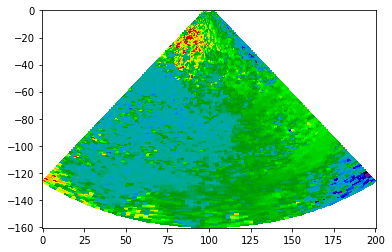

In [42]:
plt.pcolormesh(xAxis, -yAxis, resized_sample, shading='auto', cmap='nipy_spectral')
plt.show()

In [14]:
resized_average = []
resized_maximum = []
resized_minimum = []

In [15]:
for sample in resized_data:
    resized_average.append(np.mean(sample))
    resized_maximum.append(np.max(sample))
    resized_minimum.append(np.min(sample))

In [16]:
# max of maximum
np.max(resized_maximum)

0.6095982322906554

In [17]:
# min of maximum
np.min(resized_maximum)

0.015528991163791252

In [18]:
# average of maximum
np.mean(resized_maximum)

0.08002375768994417

In [19]:
# max of minimum
np.max(resized_minimum)

-0.015574967907953234

In [20]:
# min of minimum
np.min(resized_minimum)

-0.5508689353898761

In [21]:
# average of minimum
np.mean(resized_minimum)

-0.07743219179718064

In [23]:
max_by_99point9percentile = np.percentile(np.array(resized_data), 99.9)

In [24]:
max_by_99point9percentile

0.09253779320802984

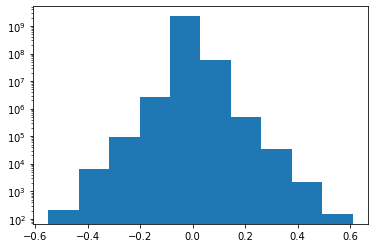

In [62]:
plt.hist(resized_data.flatten())
plt.yscale('log')
plt.show()

In [ ]:
def dice_coefficient(y_true, y_pred, axis=(1, 2, 3)):
    """
    Compute mean dice coefficient over all class
    
    Args:
        y_true (Tensorflow tensor): tensor of ground truth
                                    shape: (num_class, x_dim, y_dim, z_dim)
        y_pred (Tensorflow tensor): tensor of soft prediction for all classes
                                    shape: (num_class, x_dim, y_dim, z_dim)
        axis (tuple): spatial axis to sum over
        epsilon (float): small constant added to avoid divide by 0 error
    Return:
        dice_coefficient (float): computed value of dice coefficient
    """
    
    dice_numerator = 2. * K.sum(y_true * y_pred, axis=axis) + epsilon
    dice_denominator = K.sum(y_true, axis=axis) + K.sum(y_pred, axis=axis) + epsilon
    dice_coefficient = K.mean(dice_numerator / dice_denominator)
    
    return dice_coefficient

In [ ]:
def soft_dice_loss(y_true, y_pred, axis=(1, 2, 3), epsilon=0.00001):
    """
    Compute mean soft dice loss over all classes
    
    Args:
        y_true (Tensorflow tensor): tensor of ground truth
                                    shape: (num_class, x_dim, y_dim, z_dim)
        y_pred (Tensorflow tensor): tensor of soft prediction for all classes
                                    shape: (num_class, x_dim, y_dim, z_dim)
        axis (tuple): spatial axis to sum over
        epsilon (float): small constant added to avoid divide by 0 error
        
    Return:
        dice_loss (float): computed value of dice loss
    """
    
    dice_numerator = 2. * K.sum(y_true * y_pred, axis=axis) + epsilon
    dice_denominator = K.sum(y_true**2, axis=axis) + K.sum(y_pred**2, axis=axis) + epsilon
    dice_loss = 1 - K.mean(dice_numerator / dice_denominator)
    
    return dice_loss

In [ ]:
def create_convolution_block(input_layer, n_filters, batch_normalization=False,
                             kernel=(3, 3, 3), activation=None,
                             padding='same', strides=(1, 1, 1),
                             instance_normalization=False):
    """
    :param strides:
    :param input_layer:
    :param n_filters:
    :param batch_normalization:
    :param kernel:
    :param activation: Keras activation layer to use. (default is 'relu')
    :param padding:
    :return:
    """
    layer = Conv3D(n_filters, kernel, padding=padding, strides=strides)(
        input_layer)
    if activation is None:
        return Activation('relu')(layer)
    else:
        return activation()(layer)

In [ ]:
def get_up_convolution(n_filters, pool_size, kernel_size=(2, 2, 2),
                       strides=(2, 2, 2),
                       deconvolution=False):
    if deconvolution:
        return Conv3DTranspose(filters=n_filters, kernel_size=kernel_size,
                               strides=strides)
    else:
        return UpSampling3D(size=pool_size)

In [ ]:

def unet_model_3d(loss_function, input_shape=(4, 160, 160, 16),
                  pool_size=(2, 2, 2), n_labels=3,
                  initial_learning_rate=0.00001,
                  deconvolution=False, depth=4, n_base_filters=32,
                  include_label_wise_dice_coefficients=False, metrics=[],
                  batch_normalization=False, activation_name="sigmoid"):
    """
    Builds the 3D UNet Keras model.f
    :param metrics: List metrics to be calculated during model training (default is dice coefficient).
    :param include_label_wise_dice_coefficients: If True and n_labels is greater than 1, model will report the dice
    coefficient for each label as metric.
    :param n_base_filters: The number of filters that the first layer in the convolution network will have. Following
    layers will contain a multiple of this number. Lowering this number will likely reduce the amount of memory required
    to train the model.
    :param depth: indicates the depth of the U-shape for the model. The greater the depth, the more max pooling
    layers will be added to the model. Lowering the depth may reduce the amount of memory required for training.
    :param input_shape: Shape of the input data (n_chanels, x_size, y_size, z_size). The x, y, and z sizes must be
    divisible by the pool size to the power of the depth of the UNet, that is pool_size^depth.
    :param pool_size: Pool size for the max pooling operations.
    :param n_labels: Number of binary labels that the model is learning.
    :param initial_learning_rate: Initial learning rate for the model. This will be decayed during training.
    :param deconvolution: If set to True, will use transpose convolution(deconvolution) instead of up-sampling. This
    increases the amount memory required during training.
    :return: Untrained 3D UNet Model
    """
    inputs = Input(input_shape)
    current_layer = inputs
    levels = list()

    # add levels with max pooling
    for layer_depth in range(depth):
        layer1 = create_convolution_block(input_layer=current_layer,
                                          n_filters=n_base_filters * (
                                                  2 ** layer_depth),
                                          batch_normalization=batch_normalization)
        layer2 = create_convolution_block(input_layer=layer1,
                                          n_filters=n_base_filters * (
                                                  2 ** layer_depth) * 2,
                                          batch_normalization=batch_normalization)
        if layer_depth < depth - 1:
            current_layer = MaxPooling3D(pool_size=pool_size)(layer2)
            levels.append([layer1, layer2, current_layer])
        else:
            current_layer = layer2
            levels.append([layer1, layer2])

    # add levels with up-convolution or up-sampling
    for layer_depth in range(depth - 2, -1, -1):
        
        #print(K.int_shape(current_layer)[1])
        up_convolution = get_up_convolution(pool_size=pool_size,
                                            deconvolution=deconvolution,
                                            n_filters=K.int_shape(current_layer)[1])(current_layer)
        
        concat = concatenate([up_convolution, levels[layer_depth][1]], axis=1)
        
        #print(K.int_shape(levels[layer_depth][1])[1])
        current_layer = create_convolution_block(n_filters= K.int_shape(levels[layer_depth][1])[1],
                                                 input_layer=concat, 
                                                 batch_normalization=batch_normalization)
        
        current_layer = create_convolution_block(n_filters= K.int_shape(levels[layer_depth][1])[1],
                                                 input_layer=current_layer,
                                                 batch_normalization=batch_normalization)

    final_convolution = Conv3D(n_labels, (1, 1, 1))(current_layer)
    act = Activation(activation_name)(final_convolution)
    model = Model(inputs=inputs, outputs=act)

    if not isinstance(metrics, list):
        metrics = [metrics]

    model.compile(optimizer=Adam(lr=initial_learning_rate), loss=loss_function,
                  metrics=metrics)
    return model